## RE-TRAINING THE FACENET MODEL USING BLACK-FACES

## The Arcface loss class

In [2]:
from collections import defaultdict
import pandas as pd
import numpy as np
#from sklearn.cross_validation import train_test_split
#from sklearn.preprocessing import normalize
from scipy.stats import logistic
from os.path import join
from tqdm import tqdm
from PIL import Image
from keras import backend as K
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, Lambda, Convolution2D, MaxPooling2D, Flatten
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=10)

In [4]:

from tensorflow import keras 


from keras import regularizers



# Original paper: https://arxiv.org/pdf/1801.07698.pdf
# Original implementation: https://github.com/deepinsight/insightface
# Adapted from tensorflow implementation: https://github.com/luckycallor/InsightFace-tensorflow

from keras import backend as K
from keras.layers import Layer
from keras.metrics import categorical_accuracy

import tensorflow as tf
import math as m


class ArcFace(Layer):
    '''Custom Keras layer implementing ArcFace including:
    1. Generation of embeddings
    2. Loss function
    3. Accuracy function
    '''

    def __init__(self, output_dim, class_num, margin=0.5, scale=64., **kwargs):
        self.output_dim = output_dim
        self.class_num = class_num
        self.margin = margin
        self.s = scale

        self.cos_m = tf.math.cos(margin)
        self.sin_m = tf.math.sin(margin)
        self.mm = self.sin_m * margin
        self.threshold = tf.math.cos(tf.constant(m.pi) - margin)
        super(ArcFace, self).__init__(**kwargs)


    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(input_shape[1], self.class_num),
                                      initializer='glorot_normal',
                                      trainable=True)
        super(ArcFace, self).build(input_shape)  # Be sure to call this at the end


    def call(self, x):
        embeddings = tf.nn.l2_normalize(x, axis=1, name='normed_embeddings')
        weights = tf.nn.l2_normalize(self.kernel, axis=0, name='normed_weights')
        cos_t = tf.matmul(embeddings, weights, name='cos_t')
        return cos_t


    def get_logits(self, labels, y_pred):
        cos_t = y_pred
        cos_t2 = tf.square(cos_t, name='cos_2')
        sin_t2 = tf.subtract(1., cos_t2, name='sin_2')
        sin_t = tf.sqrt(sin_t2, name='sin_t')
        cos_mt = self.s * tf.subtract(tf.multiply(cos_t, self.cos_m), tf.multiply(sin_t, self.sin_m), name='cos_mt')
        cond_v = cos_t - self.threshold
        cond = tf.cast(tf.nn.relu(cond_v, name='if_else'), dtype=tf.bool)
        keep_val = self.s*(cos_t - self.mm)
        cos_mt_temp = tf.where(cond, cos_mt, keep_val)
        mask = tf.one_hot(labels, depth=self.class_num, name='one_hot_mask')
        inv_mask = tf.subtract(1., mask, name='inverse_mask')
        s_cos_t = tf.multiply(self.s, cos_t, name='scalar_cos_t')
        output = tf.add(tf.multiply(s_cos_t, inv_mask), tf.multiply(cos_mt_temp, mask), name='arcface_logits')
        return output


    def loss(self, y_true, y_pred):
        labels = K.argmax(y_true, axis=-1)
        logits = self.get_logits(labels, y_pred)
        loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
        return loss


    def accuracy(self, y_true, y_pred):
        labels = K.argmax(y_true, axis=-1)
        logits = self.get_logits(labels, y_pred)
        accuracy = categorical_accuracy(y_true=labels, y_pred=logits)
        return accuracy
    

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)



### Alternative implementation of arcface

In [4]:
from keras import backend as K
from keras.layers import Layer
from keras import regularizers

import tensorflow as tf


class ArcFace(Layer):
    def __init__(self, n_classes=10, s=30.0, m=0.50, regularizer=None, **kwargs):
        super(ArcFace, self).__init__(**kwargs)
        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.regularizer = regularizers.get(regularizer)

    def build(self, input_shape):
        super(ArcFace, self).build(input_shape[0])
        self.W = self.add_weight(name='W',
                                shape=(input_shape[0][-1], self.n_classes),
                                initializer='glorot_uniform',
                                trainable=True,
                                regularizer=self.regularizer)

    def call(self, inputs):
        x, y = inputs
        c = K.shape(x)[-1]
        # normalize feature
        x = tf.nn.l2_normalize(x, axis=1)
        # normalize weights
        W = tf.nn.l2_normalize(self.W, axis=0)
        # dot product
        logits = x @ W
        # add margin
        # clip logits to prevent zero division when backward
        theta = tf.acos(K.clip(logits, -1.0 + K.epsilon(), 1.0 - K.epsilon()))
        target_logits = tf.cos(theta + self.m)
        # sin = tf.sqrt(1 - logits**2)
        # cos_m = tf.cos(logits)
        # sin_m = tf.sin(logits)
        # target_logits = logits * cos_m - sin * sin_m
        #
        logits = logits * (1 - y) + target_logits * y
        # feature re-scale
        logits *= self.s
        out = tf.nn.softmax(logits)

        return out

    def compute_output_shape(self, input_shape):
        return (None, self.n_classes)


#### Importing the necessary packages

In [5]:
import tensorflow as tf
from tensorflow import keras 
from keras.preprocessing import image 
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.models import load_model

In [6]:
import os
from os import listdir

path="C:/Users/Diana/Desktop/Extracted/Training/"
count=0
for f in listdir(path):
  count=0
  for nome in listdir(path+f):
    count+=1
  print("Name: ",f,"count: ",count)




Name:  Apass count:  31
Name:  Becky count:  39
Name:  Canary count:  39
Name:  Cindy count:  52
Name:  Gamzi count:  30
Name:  Kabuura count:  23
Name:  Katatumba count:  62
Name:  KenMugabi count:  59
Name:  Lucky count:  57
Name:  Nabata count:  48
Name:  Raymond count:  21
Name:  Renal count:  26
Name:  Ruth count:  20
Name:  Samson count:  68
Name:  Vanny count:  38


In [7]:
import os
from os import listdir

path="C:/Users/Diana/Desktop/Extracted/Validation/"
count=0
for f in listdir(path):
  count=0
  for nome in listdir(path+f):
    count+=1
  print("Name: ",f,"count: ",count)

Name:  Apass count:  9
Name:  Becky count:  10
Name:  Canary count:  17
Name:  Cindy count:  17
Name:  Gamzi count:  9
Name:  Kabuura count:  8
Name:  Katatumba count:  20
Name:  KenMugabi count:  14
Name:  Lucky count:  16
Name:  Nabata count:  22
Name:  Raymond count:  6
Name:  Renal count:  8
Name:  Ruth count:  9
Name:  Samson count:  22
Name:  Vanny count:  14


#### Setting up the Image Data Generator API

In [8]:
#Import shutil first, this package deletes ipnb_checkpoints files that create a ghost class
import shutil
#The next step is to delete every ipynb_checkpoints file created by colab
#shutil.rmtree("/tmp/training/.ipynb_checkpoints") #be careful with shutil.rmtree() because it deletes every tree in that path. In other words, do not make mistakes.
#shutil.rmtree("/tmp/testing/.ipynb_checkpoints")

#specify both the training and validation directories
TRAINING_DIR="C:/Users/Diana/Desktop/Extracted/Training/"
VALIDATION_DIR="C:/Users/Diana/Desktop/Extracted/Validation/"

#Initialize Image Data Generator objects, and rescale the image 
training_datagen=ImageDataGenerator(rescale=1/255)
validation_datagen=ImageDataGenerator(rescale=1/255)

#Create the image generators that create the create the classes for all images uploaded
training_generator=training_datagen.flow_from_directory(TRAINING_DIR,class_mode='categorical',target_size=(160,160))
validation_generator=validation_datagen.flow_from_directory(VALIDATION_DIR,class_mode='categorical',target_size=(160,160))

#Load the facenet model architecture
#model=load_model('/tmp/facenet/facenet_keras.h5')


Found 613 images belonging to 15 classes.
Found 201 images belonging to 15 classes.


## Loading the facenet Model architecture

In [9]:
model=load_model('C:/Users/Diana/Desktop/facenet_keras.h5')
#A summary of the model architecture
model.summary()

Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
________________________________________________________________________________

__________________________________________________________________________________________________
Mixed_6a_Branch_1_Conv2d_0b_3x3 (None, 17, 17, 192)  0           Mixed_6a_Branch_1_Conv2d_0b_3x3_B
__________________________________________________________________________________________________
Mixed_6a_Branch_0_Conv2d_1a_3x3 (None, 8, 8, 384)    884736      Block35_5_Activation[0][0]       
__________________________________________________________________________________________________
Mixed_6a_Branch_1_Conv2d_1a_3x3 (None, 8, 8, 256)    442368      Mixed_6a_Branch_1_Conv2d_0b_3x3_A
__________________________________________________________________________________________________
Mixed_6a_Branch_0_Conv2d_1a_3x3 (None, 8, 8, 384)    1152        Mixed_6a_Branch_0_Conv2d_1a_3x3[0
__________________________________________________________________________________________________
Mixed_6a_Branch_1_Conv2d_1a_3x3 (None, 8, 8, 256)    768         Mixed_6a_Branch_1_Conv2d_1a_3x3[0
__________

__________________________________________________________________________________________________
Block17_10_Branch_0_Conv2d_1x1  (None, 8, 8, 128)    114688      Block17_9_Activation[0][0]       
__________________________________________________________________________________________________
Block17_10_Branch_1_Conv2d_0c_7 (None, 8, 8, 128)    114688      Block17_10_Branch_1_Conv2d_0b_1x7
__________________________________________________________________________________________________
Block17_10_Branch_0_Conv2d_1x1_ (None, 8, 8, 128)    384         Block17_10_Branch_0_Conv2d_1x1[0]
__________________________________________________________________________________________________
Block17_10_Branch_1_Conv2d_0c_7 (None, 8, 8, 128)    384         Block17_10_Branch_1_Conv2d_0c_7x1
__________________________________________________________________________________________________
Block17_10_Branch_0_Conv2d_1x1_ (None, 8, 8, 128)    0           Block17_10_Branch_0_Conv2d_1x1_Ba
__________

Block8_2_Branch_0_Conv2d_1x1_Ba (None, 3, 3, 192)    576         Block8_2_Branch_0_Conv2d_1x1[0][0
__________________________________________________________________________________________________
Block8_2_Branch_1_Conv2d_0c_3x1 (None, 3, 3, 192)    576         Block8_2_Branch_1_Conv2d_0c_3x1[0
__________________________________________________________________________________________________
Block8_2_Branch_0_Conv2d_1x1_Ac (None, 3, 3, 192)    0           Block8_2_Branch_0_Conv2d_1x1_Batc
__________________________________________________________________________________________________
Block8_2_Branch_1_Conv2d_0c_3x1 (None, 3, 3, 192)    0           Block8_2_Branch_1_Conv2d_0c_3x1_B
__________________________________________________________________________________________________
Block8_2_Concatenate (Concatena (None, 3, 3, 384)    0           Block8_2_Branch_0_Conv2d_1x1_Acti
                                                                 Block8_2_Branch_1_Conv2d_0c_3x1_A
__________

Total params: 22,808,144
Trainable params: 22,779,312
Non-trainable params: 28,832
__________________________________________________________________________________________________


In [10]:
print("Number of layers in the base model: ", len(model.layers))

Number of layers in the base model:  426


In [11]:
local_weights_file='C:/Users/Diana/Desktop/facenet_keras_weights.h5'
model.load_weights(local_weights_file)

for layer in model.layers:
  layer.trainable=False

In [12]:
from tensorflow.keras import layers
from tensorflow.keras import Model 

#Specify the last layer from the architecture, that you actually want
last_layer=model.get_layer('Bottleneck')
last_output=last_layer.output

### **Temporary Alternative to the above code cell**

In [19]:
!pip install tensorflow_addons

You should consider upgrading via the 'c:\users\diana\anaconda3\python.exe -m pip install --upgrade pip' command.


In [13]:
print(tensorflow_addons.__version__)

NameError: name 'tensorflow_addons' is not defined

In [16]:
#Code from arcface repo
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Dropout
import tensorflow_addons as tfa


#customizable arcface layer
af_layer = ArcFace(output_dim=128, class_num=128, margin=0.5, scale=64.)

arcface_output = af_layer(last_output)
x=layers.Flatten()(arcface_output)
#print(arcface_output)
x = Dropout(rate=0.3)(x)

x=layers.Dense(1024,activation='relu')(arcface_output)

x=layers.Dense(512,activation='relu')(x)
x = Dropout(rate=0.5)(x)
x=layers.Dense(128,activation='relu')(x)
x=layers.Dense(15,activation='softmax')(arcface_output)

model=Model(model.input,x)
model.compile(optimizer=RMSprop(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy',tf.keras.metrics.AUC(multi_label = True) , tfa.metrics.F1Score(num_classes=15), tfa.metrics.MultiLabelConfusionMatrix(num_classes=15)])

In [17]:
#training for 100 epochs
history=model.fit(training_generator,validation_data=validation_generator,epochs=100,verbose=2, callbacks=early)

Epoch 1/100
20/20 - 275s - loss: 2.7164 - accuracy: 0.0685 - auc_2: 0.5293 - f1_score: 0.0739 - Multilabel_confusion_matrix: 153.2500 - val_loss: 2.6885 - val_accuracy: 0.0945 - val_auc_2: 0.5970 - val_f1_score: 0.0695 - val_Multilabel_confusion_matrix: 50.2500
Epoch 2/100
20/20 - 202s - loss: 2.6681 - accuracy: 0.1403 - auc_2: 0.6603 - f1_score: 0.1315 - Multilabel_confusion_matrix: 153.2500 - val_loss: 2.6510 - val_accuracy: 0.1592 - val_auc_2: 0.6883 - val_f1_score: 0.1425 - val_Multilabel_confusion_matrix: 50.2500
Epoch 3/100
20/20 - 199s - loss: 2.6258 - accuracy: 0.2235 - auc_2: 0.7510 - f1_score: 0.1873 - Multilabel_confusion_matrix: 153.2500 - val_loss: 2.6150 - val_accuracy: 0.2786 - val_auc_2: 0.7409 - val_f1_score: 0.2342 - val_Multilabel_confusion_matrix: 50.2500
Epoch 4/100
20/20 - 195s - loss: 2.5867 - accuracy: 0.3622 - auc_2: 0.8141 - f1_score: 0.2892 - Multilabel_confusion_matrix: 153.2500 - val_loss: 2.5788 - val_accuracy: 0.3980 - val_auc_2: 0.7920 - val_f1_score: 0.

Epoch 33/100
20/20 - 102s - loss: 1.5593 - accuracy: 0.7243 - auc_2: 0.9830 - f1_score: 0.5759 - Multilabel_confusion_matrix: 153.2500 - val_loss: 1.6793 - val_accuracy: 0.6269 - val_auc_2: 0.9513 - val_f1_score: 0.4685 - val_Multilabel_confusion_matrix: 50.2500
Epoch 34/100
20/20 - 98s - loss: 1.5320 - accuracy: 0.7210 - auc_2: 0.9838 - f1_score: 0.5731 - Multilabel_confusion_matrix: 153.2500 - val_loss: 1.6572 - val_accuracy: 0.6269 - val_auc_2: 0.9517 - val_f1_score: 0.4682 - val_Multilabel_confusion_matrix: 50.2500
Epoch 35/100
20/20 - 103s - loss: 1.5061 - accuracy: 0.7259 - auc_2: 0.9838 - f1_score: 0.5768 - Multilabel_confusion_matrix: 153.2500 - val_loss: 1.6346 - val_accuracy: 0.6318 - val_auc_2: 0.9536 - val_f1_score: 0.4801 - val_Multilabel_confusion_matrix: 50.2500
Epoch 36/100
20/20 - 110s - loss: 1.4803 - accuracy: 0.7243 - auc_2: 0.9842 - f1_score: 0.5819 - Multilabel_confusion_matrix: 153.2500 - val_loss: 1.6118 - val_accuracy: 0.6368 - val_auc_2: 0.9539 - val_f1_score:

Epoch 65/100
20/20 - 124s - loss: 0.9395 - accuracy: 0.8320 - auc_2: 0.9910 - f1_score: 0.7642 - Multilabel_confusion_matrix: 153.2500 - val_loss: 1.1592 - val_accuracy: 0.7214 - val_auc_2: 0.9667 - val_f1_score: 0.6237 - val_Multilabel_confusion_matrix: 50.2500
Epoch 66/100
20/20 - 119s - loss: 0.9272 - accuracy: 0.8336 - auc_2: 0.9913 - f1_score: 0.7561 - Multilabel_confusion_matrix: 153.2500 - val_loss: 1.1487 - val_accuracy: 0.7214 - val_auc_2: 0.9670 - val_f1_score: 0.6237 - val_Multilabel_confusion_matrix: 50.2500
Epoch 67/100
20/20 - 122s - loss: 0.9138 - accuracy: 0.8467 - auc_2: 0.9912 - f1_score: 0.7757 - Multilabel_confusion_matrix: 153.2500 - val_loss: 1.1383 - val_accuracy: 0.7313 - val_auc_2: 0.9673 - val_f1_score: 0.6412 - val_Multilabel_confusion_matrix: 50.2500
Epoch 68/100
20/20 - 125s - loss: 0.9003 - accuracy: 0.8499 - auc_2: 0.9914 - f1_score: 0.7879 - Multilabel_confusion_matrix: 153.2500 - val_loss: 1.1286 - val_accuracy: 0.7264 - val_auc_2: 0.9672 - val_f1_score

Epoch 97/100
20/20 - 127s - loss: 0.6386 - accuracy: 0.9152 - auc_2: 0.9941 - f1_score: 0.8934 - Multilabel_confusion_matrix: 153.2500 - val_loss: 0.9144 - val_accuracy: 0.7861 - val_auc_2: 0.9725 - val_f1_score: 0.7275 - val_Multilabel_confusion_matrix: 50.2500
Epoch 98/100
20/20 - 130s - loss: 0.6322 - accuracy: 0.9119 - auc_2: 0.9943 - f1_score: 0.8924 - Multilabel_confusion_matrix: 153.2500 - val_loss: 0.9093 - val_accuracy: 0.7861 - val_auc_2: 0.9725 - val_f1_score: 0.7275 - val_Multilabel_confusion_matrix: 50.2500
Epoch 99/100
20/20 - 125s - loss: 0.6242 - accuracy: 0.9184 - auc_2: 0.9943 - f1_score: 0.8977 - Multilabel_confusion_matrix: 153.2500 - val_loss: 0.9040 - val_accuracy: 0.7861 - val_auc_2: 0.9727 - val_f1_score: 0.7275 - val_Multilabel_confusion_matrix: 50.2500
Epoch 100/100
20/20 - 128s - loss: 0.6195 - accuracy: 0.9168 - auc_2: 0.9943 - f1_score: 0.8959 - Multilabel_confusion_matrix: 153.2500 - val_loss: 0.8991 - val_accuracy: 0.7861 - val_auc_2: 0.9730 - val_f1_scor

### Lets visualize the output of the training phase

## 413 from 426

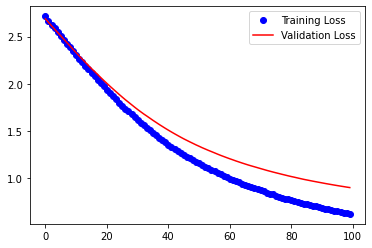

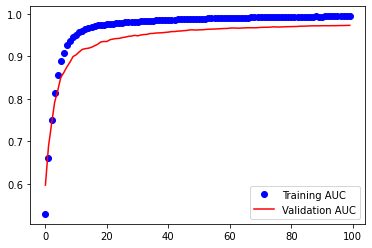

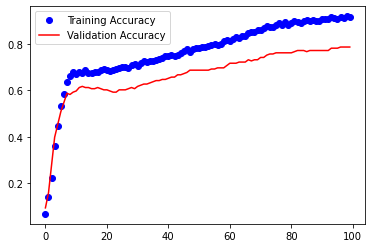

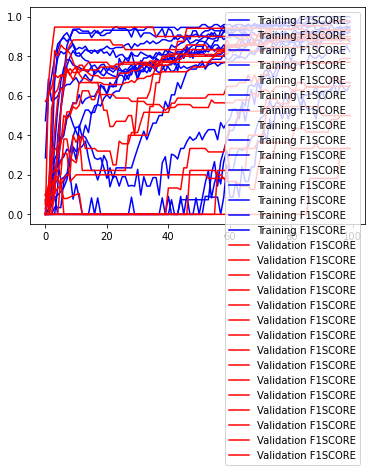

ValueError: x and y can be no greater than 2-D, but have shapes (100,) and (100, 15, 2, 2)

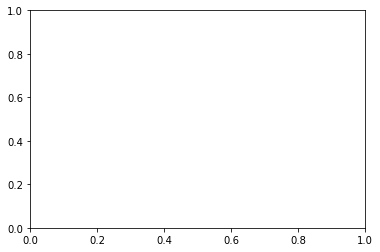

In [20]:
auc=history.history['auc_2']
val_auc=history.history['val_auc_2']

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

f1_score=history.history['f1_score']
val_f1_score=history.history['val_f1_score']

Multilabel_confusion_matrix=history.history['Multilabel_confusion_matrix']
val_Multilabel_confusion_matrix=history.history['val_Multilabel_confusion_matrix']

epochs=range(len(acc))

import matplotlib.pyplot as plt

plt.plot(epochs,loss,'bo',label="Training Loss")
plt.plot(epochs,val_loss,'r',label="Validation Loss")
plt.legend()
plt.show()


plt.plot(epochs,auc,'bo',label="Training AUC")
plt.plot(epochs,val_auc,'r',label="Validation AUC")
plt.legend()
plt.figure()

plt.plot(epochs,acc,'bo',label="Training Accuracy")
plt.plot(epochs,val_acc,'r',label="Validation Accuracy")
plt.legend()
plt.show()

plt.plot(epochs,f1_score,'b',label="Training F1SCORE")
plt.plot(epochs,val_f1_score,'r',label="Validation F1SCORE")
plt.legend()
plt.show()

plt.plot(epochs,Multilabel_confusion_matrix,'b',label="Training Multilable CM")
plt.plot(epochs,val_Multilabel_confusion_matrix,'r',label="Validation Multilable CM")
plt.legend()
plt.show()


In [ ]:
model.summary()

In [ ]:
model2=Model(model.input,model.layers[-3].output)
model2.summary()

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
sess=tf.Session()
from tensorflow.python.framework import graph_io
frozen = tf.graph_util.convert_variables_to_constants(sess, sess.graph_def, ["name_of_the_output_node"])
graph_io.write_graph(frozen, '/tmp/session-frozens', 'inference_graph.pb', as_text=False)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from keras import backend as K 
from keras.models import Sequential, Model


sess=tf.Session()
K.set_learning_phase(0)   # Set the learning phase to 0
model = model2 
config = model2.get_config()
#weights = model2.get_weights()
#model = Sequential.from_config(config)
output_node = model2.output.name.split(':')[0]  # We need this in the next step
graph_file = "kerasFacenet.pb" 
ckpt_file = "kerasFacenet.ckpt"
saver = tf.train.Saver(sharded=True)
tf.train.write_graph(sess.graph_def, '', graph_file)
#saver.save(sess, ckpt_file) 

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

tf.saved_model.save(model2, "/tmp/saved-models")

# Convert Keras model to ConcreteFunction
full_model = tf.function(lambda x: model2(x))
full_model = full_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

# Get frozen ConcreteFunction
frozen_func = convert_variables_to_constants_v2(full_model)
frozen_func.graph.as_graph_def()

layers = [op.name for op in frozen_func.graph.get_operations()]
#print("-" * 50)
#print("Frozen model layers: ")
for layer in layers:
    print(layer)

#print("-" * 50)
#print("Frozen model inputs: ")
#print(frozen_func.inputs)
#print("Frozen model outputs: ")
#print(frozen_func.outputs)

# Save frozen graph from frozen ConcreteFunction to hard drive
tf.io.write_graph(graph_or_graph_def=frozen_func.graph,
                  logdir="/tmp/saved-model",
                  name="facenet-Original-LastLayer.pb",
                  as_text=False)
